##Calculating the Probability of Future Customer Engagement

In non-subscription retail models, customers come and go with no long-term commitments, making it very difficult to determine whether a customer will return in the future. Determining the probability that a customer will re-engage is critical to the design of effective marketing campaigns. Different messaging and promotions may be required to incentivize customers who have likely dropped out to return to our stores. Engaged customers may be more responsive to marketing that encourages them to expand the breadth and scale of purchases with us. Understanding where our customers land with regard to the probability of future engagement is critical to tailoring our marketing efforts to them.  

The *Buy 'til You Die* (BTYD) models popularized by Peter Fader and others leverage two basic customer metrics, *i.e.* the recency of a customer's last engagement and the frequency of repeat transactions over a customer's lifetime, to derive a probability of future re-engagement. This is done by fitting customer history to curves describing the distribution of purchase frequencies and engagement drop-off following a prior purchase. The math behind these models is fairly complex but thankfully it's been encapsulated in the [lifetimes](https://pypi.org/project/Lifetimes/) library, making it much easier for traditional enterprises to employ. The purpose of this notebook is to examine how these models may be applied to customer transaction history and how they may be deployed for integration in marketing processes.

###Step 1: Setup the Environment

To run this notebook, you need to attach to a **Databricks ML Runtime** cluster leveraging Databricks version 6.5+. This version of the Databricks runtime will provide access to many of the pre-configured libraries used here.  Still, there are additional Python libraries which you will need to install and attach to your cluster.  These are:</p>

* xlrd
* lifetimes==0.10.1
* nbconvert

To install these libraries in your Databricks workspace, please follow [these steps](https://docs.databricks.com/libraries.html#workspace-libraries) using the PyPI library source in combination with the bullet-pointed library names in the provided list.  Once installed, please be sure to [attach](https://docs.databricks.com/libraries.html#install-a-library-on-a-cluster) these libraries to the cluster with which you are running this notebook.

With the libraries installed, let's load a sample dataset with which we can examine the BTYD models. The dataset we will use is the [Online Retail Data Set](http://archive.ics.uci.edu/ml/datasets/Online+Retail) available from the UCI Machine Learning Repository.  This dataset is made available as a Microsoft Excel workbook (XLSX).  Having downloaded this XLSX file to our local system, we can load it into our Databricks environment by following the steps provided [here](https://docs.databricks.com/data/tables.html#create-table-ui). Please note when performing the file import, you don't need to select the *Create Table with UI* or the *Create Table in Notebook* options to complete the import process. Also, the name of the XLSX file will be modified upon import as it includes an unsupported space character.  As a result, we will need to programmatically locate the new name for the file assigned by the import process.

Assuming we've uploaded the XLSX to the */FileStore/tables/online_retail/*, we can access it as follows:

In [0]:
import pandas as pd
import numpy as np

# identify name of xlsx file (which will change when uploaded)
xlsx_filename = dbutils.fs.ls('file:///dbfs/FileStore/tables/online_retail')[0][0]

# schema of the excel spreadsheet data range
orders_schema = {
  'InvoiceNo':np.str,
  'StockCode':np.str,
  'Description':np.str,
  'Quantity':np.int64,
  'InvoiceDate':np.datetime64,
  'UnitPrice':np.float64,
  'CustomerID':np.str,
  'Country':np.str  
  }

# read spreadsheet to pandas dataframe
# the xlrd library must be installed for this step to work 
orders_pd = pd.read_excel(
  xlsx_filename, 
  sheet_name='Online Retail',
  header=0, # first row is header
  dtype=orders_schema
  )

# display first few rows from the dataset
orders_pd.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


The data in the workbook are organized as a range in the Online Retail spreadsheet.  Each record represents a line item in a sales transaction. The fields included in the dataset are:

| Field | Description |
|-------------:|-----:|
|InvoiceNo|A 6-digit integral number uniquely assigned to each transaction|
|StockCode|A 5-digit integral number uniquely assigned to each distinct product|
|Description|The product (item) name|
|Quantity|The quantities of each product (item) per transaction|
|InvoiceDate|The invoice date and a time in mm/dd/yy hh:mm format|
|UnitPrice|The per-unit product price in pound sterling (£)|
|CustomerID| A 5-digit integral number uniquely assigned to each customer|
|Country|The name of the country where each customer resides|

Of these fields, the ones of particular interest for our work are InvoiceNo which identifies the transaction, InvoiceDate which identifies the date of that transaction, and CustomerID which uniquely identifies the customer across multiple transactions. (In a separate notebook, we will examine the monetary value of the transactions through the UnitPrice and Quantity fields.)

###Step 2: Explore the Dataset

To enable the exploration of the data using SQL statements, let's flip the pandas DataFrame into a Spark DataFrame and persist it as a temporary view:

In [0]:
# convert pandas DF to Spark DF
orders = spark.createDataFrame(orders_pd)

# present Spark DF as queriable view
orders.createOrReplaceTempView('orders') 

Examining the transaction activity in our dataset, we can see the first transaction occurs December 1, 2010 and the last is on December 9, 2011 making this a dataset that's a little more than 1 year in duration. The daily transaction count shows there is quite a bit of volatility in daily activity for this online retailer:

In [0]:
%sql -- unique transactions by date

SELECT 
  TO_DATE(InvoiceDate) as InvoiceDate,
  COUNT(DISTINCT InvoiceNo) as Transactions
FROM orders
GROUP BY TO_DATE(InvoiceDate)
ORDER BY InvoiceDate;

InvoiceDate,Transactions
2010-12-01,143
2010-12-02,167
2010-12-03,108
2010-12-05,95
2010-12-06,133
2010-12-07,111
2010-12-08,148
2010-12-09,183
2010-12-10,91
2010-12-12,51


We can smooth this out a bit by summarizing activity by month. It's important to keep in mind that December 2011 only consists of 9 days so the sales decline graphed for the last month should most likely be ignored:

NOTE We will hide the SQL behind each of the following result sets for ease of viewing.  To view this code, simply click the **Show code** item above each of the following charts.

In [0]:
%sql -- unique transactions by month

SELECT 
  TRUNC(InvoiceDate, 'month') as InvoiceMonth,
  COUNT(DISTINCT InvoiceNo) as Transactions
FROM orders
GROUP BY TRUNC(InvoiceDate, 'month') 
ORDER BY InvoiceMonth;

InvoiceMonth,Transactions
2010-12-01,2025
2011-01-01,1476
2011-02-01,1393
2011-03-01,1983
2011-04-01,1744
2011-05-01,2162
2011-06-01,2012
2011-07-01,1927
2011-08-01,1737
2011-09-01,2327


For the little more than 1-year period for which we have data, we see over four-thousand unique customers.  These customers generated about twenty-two thousand unique transactions:

In [0]:
%sql -- unique customers and transactions

SELECT
 COUNT(DISTINCT CustomerID) as Customers,
 COUNT(DISTINCT InvoiceNo) as Transactions
FROM orders
WHERE CustomerID IS NOT NULL;

Customers,Transactions
4372,22190


A little quick math may lead us to estimate that, on average, each customer is responsible for about 5 transactions, but this would not provide an accurate representation of customer activity.

Instead, if we count the unique transactions by customer and then examine the frequency of these values, we see that many of the customers have engaged in a single transaction. The distribution of the count of repeat purchases declines from there in a manner that we may describe as negative binomial distribution (which is the basis of the NBD acronym included in the name of most BTYD models):

In [0]:
%sql -- the distribution of per-customer transaction counts 

SELECT
  x.Transactions,
  COUNT(x.*) as Occurrences
FROM (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) as Transactions 
  FROM orders
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
  ) x
GROUP BY 
  x.Transactions
ORDER BY
  x.Transactions;

Transactions,Occurrences
1,1313
2,817
3,490
4,377
5,288
6,196
7,157
8,117
9,80
10,78


If we alter our last analysis to group a customer's transactions that occur on the same date into a single transaction - a pattern that aligns with metrics we will calculate later - we see that a few more customers are identified as non-repeat customers but the overall pattern remains the same:

In [0]:
%sql -- the distribution of per-customer transaction counts
     -- with consideration of same-day transactions as a single transaction 

SELECT
  x.Transactions,
  COUNT(x.*) as Occurances
FROM (
  SELECT
    CustomerID,
    COUNT(DISTINCT TO_DATE(InvoiceDate)) as Transactions
  FROM orders
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
  ) x
GROUP BY 
  x.Transactions
ORDER BY
  x.Transactions;

Transactions,Occurances
1,1381
2,858
3,499
4,388
5,277
6,197
7,149
8,116
9,70
10,71


Focusing on customers with repeat purchases, we can examine the distribution of the days between purchase events. What's important to note here is that most customers return to the site within 2 to 3 months of a prior purchase.  Longer gaps do occur but significantly fewer customers have longer gaps between returns.  This is important to understand in the context of our BYTD models in that the time since we last saw a customer is a critical factor to determining whether they will ever come back with the probability of return dropping as more and more time passes since a customer's last purchase event:

In [0]:
%sql -- distribution of per-customer average number of days between purchase events

WITH CustomerPurchaseDates
  AS (
    SELECT DISTINCT
      CustomerID,
      TO_DATE(InvoiceDate) as InvoiceDate
    FROM orders 
    WHERE CustomerId IS NOT NULL
    )
SELECT -- Per-Customer Average Days Between Purchase Events
  AVG(
    DATEDIFF(a.NextInvoiceDate, a.InvoiceDate)
    ) as AvgDaysBetween
FROM ( -- Purchase Event and Next Purchase Event by Customer
  SELECT 
    x.CustomerID,
    x.InvoiceDate,
    MIN(y.InvoiceDate) as NextInvoiceDate
  FROM CustomerPurchaseDates x
  INNER JOIN CustomerPurchaseDates y
    ON x.CustomerID=y.CustomerID AND x.InvoiceDate < y.InvoiceDate
  GROUP BY 
    x.CustomerID,
    x.InvoiceDate
    ) a
GROUP BY CustomerID

AvgDaysBetween
154.0
110.0
40.4
45.5
103.0
77.0
266.0
23.866666666666667
23.8
97.5


###Step 3: Calculate Customer Metrics

The dataset with which we are working consists of raw transactional history.  To apply the BTYD models, we need to derive several per-customer metrics:</p>

* **Frequency** - the number of dates on which a customer made a purchase subsequent to the date of the customer's first purchase
* **Age (T)** - the number of time units, *e.g.* days, since the date of a customer's first purchase to the current date (or last date in the dataset)
* **Recency** - the age of the customer (as previously defined) at the time of their last purchase

It's important to note that when calculating metrics such as customer age that we need to consider when our dataset terminates.  Calculating these metrics relative to today's date can lead to erroneous results.  Given this, we will identify the last date in the dataset and define that as *today's date* for all calculations.

To get started with these calculations, let's take a look at how they are performed using the built-in functionality of the lifetimes library:

In [0]:
import lifetimes

# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()

# calculate the required customer metrics
metrics_pd = (
  lifetimes.utils.summary_data_from_transaction_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date, 
    freq='D'
    )
  )

# display first few rows
metrics_pd.head(10)

,frequency,recency,T
CustomerID,,,
12346,0.0,0.0,325.0
12347,6.0,365.0,367.0
12348,3.0,283.0,358.0
12349,0.0,0.0,18.0
12350,0.0,0.0,310.0
12352,6.0,260.0,296.0
12353,0.0,0.0,204.0
12354,0.0,0.0,232.0
12355,0.0,0.0,214.0


The lifetimes library, like many Python libraries, is single-threaded.  Using this library to derive customer metrics on larger transactional datasets may overwhelm your system or simply take too long to complete. For this reason, let's examine how these metrics can be calculated using the distributed capabilities of Apache Spark.

As SQL is frequency employed for complex data manipulation, we'll start with a Spark SQL statement.  In this statement, we first assemble each customer's order history consisting of the customer's ID, the date of their first purchase (first_at), the date on which a purchase was observed (transaction_at) and the current date (using the last date in the dataset for this value).  From this history, we can count the number of repeat transaction dates (frequency), the days between the last and first transaction dates (recency), and the days between the current date and first transaction (T) on a per-customer basis:

In [0]:
# sql statement to derive summary customer stats
sql = '''
  SELECT
    a.customerid as CustomerID,
    CAST(COUNT(DISTINCT a.transaction_at) - 1 as float) as frequency,
    CAST(DATEDIFF(MAX(a.transaction_at), a.first_at) as float) as recency,
    CAST(DATEDIFF(a.current_dt, a.first_at) as float) as T
  FROM ( -- customer order history
    SELECT DISTINCT
      x.customerid,
      z.first_at,
      TO_DATE(x.invoicedate) as transaction_at,
      y.current_dt
    FROM orders x
    CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_dt FROM orders) y                                -- current date (according to dataset)
    INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) z  -- first order per customer
      ON x.customerid=z.customerid
    WHERE x.customerid IS NOT NULL
    ) a
  GROUP BY a.customerid, a.current_dt, a.first_at
  ORDER BY CustomerID
  '''

# capture stats in dataframe 
metrics_sql = spark.sql(sql)

# display stats
display(metrics_sql)  

CustomerID,frequency,recency,T
12346,0.0,0.0,325.0
12347,6.0,365.0,367.0
12348,3.0,283.0,358.0
12349,0.0,0.0,18.0
12350,0.0,0.0,310.0
12352,6.0,260.0,296.0
12353,0.0,0.0,204.0
12354,0.0,0.0,232.0
12355,0.0,0.0,214.0
12356,2.0,303.0,325.0


Of course, Spark SQL does not require the DataFrame to be accessed exclusively using a SQL statement.  We may derive this same result using the Programmatic SQL API which may align better with some Data Scientist's preferences.  The code in the next cell is purposely assembled to mirror the structure in the previous SQL statement for the purposes of comparison:

In [0]:
from pyspark.sql.functions import to_date, datediff, max, min, countDistinct, count, sum, when
from pyspark.sql.types import *

# valid customer orders
x = orders.where(orders.CustomerID.isNotNull())

# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(max(to_date(orders.InvoiceDate)).alias('current_dt'))
  )

# calculate first transaction date by customer
z = (
  orders
    .groupBy(orders.CustomerID)
    .agg(min(to_date(orders.InvoiceDate)).alias('first_at'))
  )

# combine customer history with date info 
a = (x
    .crossJoin(y)
    .join(z, x.CustomerID==z.CustomerID, how='inner')
    .select(
      x.CustomerID.alias('customerid'), 
      z.first_at, 
      to_date(x.InvoiceDate).alias('transaction_at'), 
      y.current_dt
      )
     .distinct()
    )

# calculate relevant metrics by customer
metrics_api = (a
           .groupBy(a.customerid, a.current_dt, a.first_at)
           .agg(
             (countDistinct(a.transaction_at)-1).cast(FloatType()).alias('frequency'),
             datediff(max(a.transaction_at), a.first_at).cast(FloatType()).alias('recency'),
             datediff(a.current_dt, a.first_at).cast(FloatType()).alias('T')
             )
           .select('customerid','frequency','recency','T')
           .orderBy('customerid')
          )

display(metrics_api)

customerid,frequency,recency,T
12346,0.0,0.0,325.0
12347,6.0,365.0,367.0
12348,3.0,283.0,358.0
12349,0.0,0.0,18.0
12350,0.0,0.0,310.0
12352,6.0,260.0,296.0
12353,0.0,0.0,204.0
12354,0.0,0.0,232.0
12355,0.0,0.0,214.0
12356,2.0,303.0,325.0


Let's take a moment to compare the data in these different metrics datasets, just to confirm the results are identical.  Instead of doing this record by record, let's calculate summary statistics across each dataset to verify their consistency:

NOTE You may notice means and standard deviations vary slightly in the hundred-thousandths and millionths decimal places.  This is a result of slight differences in data types between the pandas and Spark DataFrames but do not affect our results in a meaningful way.

In [0]:
# summary data from lifetimes
metrics_pd.describe()

,frequency,recency,T
count,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209
std,6.674343,133.000474,118.384168
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,115.000000
50%,1.000000,98.000000,253.000000
75%,4.000000,256.000000,331.000000
max,145.000000,373.000000,373.000000


In [0]:
# summary data from SQL statement
metrics_sql.toPandas().describe()

,frequency,recency,T
count,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723007,225.304214
std,6.674344,133.000473,118.384171
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,115.000000
50%,1.000000,98.000000,253.000000
75%,4.000000,256.000000,331.000000
max,145.000000,373.000000,373.000000


In [0]:
# summary data from pyspark.sql API
metrics_api.toPandas().describe()

,frequency,recency,T
count,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723007,225.304214
std,6.674344,133.000473,118.384171
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,115.000000
50%,1.000000,98.000000,253.000000
75%,4.000000,256.000000,331.000000
max,145.000000,373.000000,373.000000


The metrics we've calculated represent summaries of a time series of data.  To support model validation and avoid overfitting, a common pattern with time series data is to train models on an earlier portion of the time series (known as the *calibration* period) and validate against a later portion of the time series (known as the *holdout* period). In the lifetimes library, the derivation of per customer metrics using calibration and holdout periods is done through a simple method call.  Because our dataset consists of a limited range for data, we will instruct this library method to use the last 90-days of data as the holdout period.  A simple parameter called a widget on the Databricks platform has been implemented to make the configuration of this setting easily changeable:

NOTE To change the number of days in the holdout period, look for the textbox widget by scrolling to the top of your Databricks notebook after running this next cell

In [0]:
# define a notebook parameter making holdout days configurable (90-days default)
dbutils.widgets.text('holdout days', '90')

In [0]:
from datetime import timedelta

# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()

# define end of calibration period
holdout_days = int(dbutils.widgets.get('holdout days'))
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal_pd = (
  lifetimes.utils.calibration_and_holdout_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D'    
    )
  )

# display first few rows
metrics_cal_pd.head(10)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,235.0,0.0,<90 * Days>
12347,4.0,238.0,277.0,2.0,<90 * Days>
12348,2.0,110.0,268.0,1.0,<90 * Days>
12350,0.0,0.0,220.0,0.0,<90 * Days>
12352,3.0,34.0,206.0,3.0,<90 * Days>
12353,0.0,0.0,114.0,0.0,<90 * Days>
12354,0.0,0.0,142.0,0.0,<90 * Days>
12355,0.0,0.0,124.0,0.0,<90 * Days>
12356,1.0,80.0,235.0,1.0,<90 * Days>


As before, we may leverage Spark SQL to derive this same information.  Again, we'll examine this through both a SQL statement and the programmatic SQL API.

To understand the SQL statement, first recognize that it's divided into two main parts.  In the first, we calculate the core metrics, *i.e.* recency, frequency and age (T), per customer for the calibration period, much like we did in the previous query example. In the second part of the query, we calculate the number of purchase dates in the holdout customer for each customer.  This value (frequency_holdout) represents the incremental value to be added to the frequency for the calibration period (frequency_cal) when we examine a customer's entire transaction history across both calibration and holdout periods.

To simplify our logic, a common table expression (CTE) named CustomerHistory is defined at the top of the query.  This query extracts the relevant dates that make up a customer's transaction history and closely mirrors the logic at the center of the last SQL statement we examined.  The only difference is that we include the number of days in the holdout period (duration_holdout):

In [0]:
sql = '''
WITH CustomerHistory 
  AS (
    SELECT  -- nesting req'ed b/c can't SELECT DISTINCT on widget parameter
      m.*,
      getArgument('holdout days') as duration_holdout
    FROM (
      SELECT DISTINCT
        x.customerid,
        z.first_at,
        TO_DATE(x.invoicedate) as transaction_at,
        y.current_dt
      FROM orders x
      CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_dt FROM orders) y                                -- current date (according to dataset)
      INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) z  -- first order per customer
        ON x.customerid=z.customerid
      WHERE x.customerid IS NOT NULL
    ) m
  )
SELECT
    a.customerid as CustomerID,
    a.frequency as frequency_cal,
    a.recency as recency_cal,
    a.T as T_cal,
    COALESCE(b.frequency_holdout, 0.0) as frequency_holdout,
    a.duration_holdout
FROM ( -- CALIBRATION PERIOD CALCULATIONS
    SELECT
        p.customerid,
        CAST(p.duration_holdout as float) as duration_holdout,
        CAST(DATEDIFF(MAX(p.transaction_at), p.first_at) as float) as recency,
        CAST(COUNT(DISTINCT p.transaction_at) - 1 as float) as frequency,
        CAST(DATEDIFF(DATE_SUB(p.current_dt, p.duration_holdout), p.first_at) as float) as T
    FROM CustomerHistory p
    WHERE p.transaction_at < DATE_SUB(p.current_dt, p.duration_holdout)  -- LIMIT THIS QUERY TO DATA IN THE CALIBRATION PERIOD
    GROUP BY p.customerid, p.first_at, p.current_dt, p.duration_holdout
  ) a
LEFT OUTER JOIN ( -- HOLDOUT PERIOD CALCULATIONS
  SELECT
    p.customerid,
    CAST(COUNT(DISTINCT p.transaction_at) as float) as frequency_holdout
  FROM CustomerHistory p
  WHERE 
    p.transaction_at >= DATE_SUB(p.current_dt, p.duration_holdout) AND  -- LIMIT THIS QUERY TO DATA IN THE HOLDOUT PERIOD
    p.transaction_at <= p.current_dt
  GROUP BY p.customerid
  ) b
  ON a.customerid=b.customerid
ORDER BY CustomerID
'''

metrics_cal_sql = spark.sql(sql)
display(metrics_cal_sql)

CustomerID,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
12346,0.0,0.0,235.0,0.0,90.0
12347,4.0,238.0,277.0,2.0,90.0
12348,2.0,110.0,268.0,1.0,90.0
12350,0.0,0.0,220.0,0.0,90.0
12352,3.0,34.0,206.0,3.0,90.0
12353,0.0,0.0,114.0,0.0,90.0
12354,0.0,0.0,142.0,0.0,90.0
12355,0.0,0.0,124.0,0.0,90.0
12356,1.0,80.0,235.0,1.0,90.0
12358,0.0,0.0,60.0,1.0,90.0


And here is the equivalent Programmatic SQL API logic:

In [0]:
from pyspark.sql.functions import avg, date_sub, coalesce, lit, expr

# valid customer orders
x = orders.where(orders.CustomerID.isNotNull())

# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(max(to_date(orders.InvoiceDate)).alias('current_dt'))
  )

# calculate first transaction date by customer
z = (
  orders
    .groupBy(orders.CustomerID)
    .agg(min(to_date(orders.InvoiceDate)).alias('first_at'))
  )

# combine customer history with date info (CUSTOMER HISTORY)
p = (x
    .crossJoin(y)
    .join(z, x.CustomerID==z.CustomerID, how='inner')
    .withColumn('duration_holdout', lit(int(dbutils.widgets.get('holdout days'))))
    .select(
      x.CustomerID.alias('customerid'),
      z.first_at, 
      to_date(x.InvoiceDate).alias('transaction_at'), 
      y.current_dt, 
      'duration_holdout'
      )
     .distinct()
    )

# calculate relevant metrics by customer
# note: date_sub requires a single integer value unless employed within an expr() call
a = (p
       .where(p.transaction_at < expr('date_sub(current_dt, duration_holdout)')) 
       .groupBy(p.customerid, p.current_dt, p.duration_holdout, p.first_at)
       .agg(
         (countDistinct(p.transaction_at)-1).cast(FloatType()).alias('frequency_cal'),
         datediff( max(p.transaction_at), p.first_at).cast(FloatType()).alias('recency_cal'),
         datediff( expr('date_sub(current_dt, duration_holdout)'), p.first_at).cast(FloatType()).alias('T_cal')
       )
    )

b = (p
      .where((p.transaction_at >= expr('date_sub(current_dt, duration_holdout)')) & (p.transaction_at <= p.current_dt) )
      .groupBy(p.customerid)
      .agg(
        countDistinct(p.transaction_at).cast(FloatType()).alias('frequency_holdout')
        )
   )

metrics_cal_api = (a
                 .join(b, a.customerid==b.customerid, how='left')
                 .select(
                   a.customerid.alias('CustomerID'),
                   a.frequency_cal,
                   a.recency_cal,
                   a.T_cal,
                   coalesce(b.frequency_holdout, lit(0.0)).alias('frequency_holdout'),
                   a.duration_holdout
                   )
                 .orderBy('CustomerID')
              )

display(metrics_cal_api)

CustomerID,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
12346,0.0,0.0,235.0,0.0,90
12347,4.0,238.0,277.0,2.0,90
12348,2.0,110.0,268.0,1.0,90
12350,0.0,0.0,220.0,0.0,90
12352,3.0,34.0,206.0,3.0,90
12353,0.0,0.0,114.0,0.0,90
12354,0.0,0.0,142.0,0.0,90
12355,0.0,0.0,124.0,0.0,90
12356,1.0,80.0,235.0,1.0,90
12358,0.0,0.0,60.0,1.0,90


Using summary stats, we can again verify these different units of logic are returning the same results:

In [0]:
# summary data from lifetimes
metrics_cal_pd.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000
mean,2.677608,90.587046,185.041618,1.502345
std,5.222838,96.077761,80.771943,2.495318
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,125.000000,0.000000
50%,1.000000,59.500000,197.000000,1.000000
75%,3.000000,175.000000,268.000000,2.000000
max,93.000000,282.000000,283.000000,52.000000


In [0]:
# summary data from SQL statement
metrics_cal_sql.toPandas().describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587044,185.041611,1.502345,90.0
std,5.222837,96.077766,80.771942,2.495318,0.0
min,0.000000,0.000000,1.000000,0.000000,90.0
25%,0.000000,0.000000,125.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,1.000000,90.0
75%,3.000000,175.000000,268.000000,2.000000,90.0
max,93.000000,282.000000,283.000000,52.000000,90.0


In [0]:
# summary data from pyspark.sql API
metrics_cal_api.toPandas().describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587044,185.041611,1.502345,90.0
std,5.222837,96.077766,80.771942,2.495318,0.0
min,0.000000,0.000000,1.000000,0.000000,90.0
25%,0.000000,0.000000,125.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,1.000000,90.0
75%,3.000000,175.000000,268.000000,2.000000,90.0
max,93.000000,282.000000,283.000000,52.000000,90.0


Our data prep is nearly done.  The last thing we need to do is exclude customers for which we have no repeat purchases, *i.e.* frequency or frequency_cal is 0. The Pareto/NBD and BG/NBD models we will use focus exclusively on performing calculations on customers with repeat transactions.  A modified BG/NBD model, *i.e.* MBG/NBD, which allows for customers with no repeat transactions is supported by the lifetimes library.  However, to stick with the two most popular of the BYTD models in use today, we will limit our data to align with their requirements:

NOTE We are showing how both the pandas and Spark DataFrames are filtered simply to be consistent with side-by-side comparisons earlier in this section of the notebook.  In a real-world implementation, you would simply choose to work with pandas or Spark DataFrames for data preparation.

In [0]:
# remove customers with no repeats (complete dataset)
filtered_pd = metrics_pd[metrics_pd['frequency'] > 0]
filtered = metrics_api.where(metrics_api.frequency > 0)

## remove customers with no repeats in calibration period
filtered_cal_pd = metrics_cal_pd[metrics_cal_pd['frequency_cal'] > 0]
filtered_cal = metrics_cal_api.where(metrics_cal_api.frequency_cal > 0)

###Step 4: Train the Model

To ease into the training of a model, let's start with a simple exercise using a [Pareto/NBD model](https://www.jstor.org/stable/2631608), the original BTYD model. We'll use the calibration-holdout dataset constructed in the last section of this notebook, fitting the model to the calibration data and later evaluating it using the holdout data:

In [0]:
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

# load spark dataframe to pandas dataframe
input_pd = filtered_cal.toPandas()

# fit a model
model = ParetoNBDFitter(penalizer_coef=0.0)
model.fit( input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

Out[17]: <lifetimes.ParetoNBDFitter: fitted with 2163 subjects, alpha: 96.96, beta: 3014.97, r: 1.99, s: 0.84>

With our model now fit, let's make some predictions for the holdout period.  We'll grab the actuals for that same period to enable comparison in a subsequent step:

In [0]:
# get predicted frequency during holdout period
frequency_holdout_predicted = model.predict( input_pd['duration_holdout'], input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

# get actual frequency during holdout period
frequency_holdout_actual = input_pd['frequency_holdout']

/databricks/python/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
 return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

With actual and predicted values in hand, we can calculate some standard evaluation metrics.  Let's wrap those calculations in a function call to make evaluation easier in future steps:

In [0]:
import numpy as np

def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# score the model
print('MSE: {0}'.format(score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')))

MSE: 3.102822341084317

While the internals of the Pareto/NBD model may be quite complex.  In a nutshell, the model calculates a double integral of two curves, one which describes the frequency of customer purchases within a population and another which describes customer survivorship following a prior purchase event. All of the calculation logic is thankfully hidden behind a simple method call.

As simple as training a model may be, we have two models that we could use here: the Pareto/NBD model and the BG/NBD model.  The [BG/NBD model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) simplifies the math involved in calculating customer lifetime and is the model that popularized the BTYD approach.  Both models work off the same customer features and employ the same constraints.  (The primary difference between the two models is that the BG/NBD model maps the survivorship curve to a beta-geometric distribution instead of a Pareto distribution.) To achieve the best fit possible, it is worthwhile to compare the results of both models with our dataset.

Each model leverages an L2-norm regularization parameter which we've arbitrarily set to 0 in the previous training cycle.  In addition to exploring which model works best, we should consider which value (between 0 and 1) works best for this parameter.  This gives us a pretty broad search space to explore with some hyperparameter tuning.

To assist us with this, we will make use of [hyperopt](http://hyperopt.github.io/hyperopt/).  Hyperopt allows us to parallelize the training and evaluation of models against a hyperparameter search space.  This can be done leveraging the multiprocessor resources of a single machine or across the broader resources provided by a Spark cluster.  With each model iteration, a loss function is calculated.  Using various optimization algorithms, hyperopt navigates the search space to locate the best available combination of parameter settings to minimize the value returned by the loss function.

To make use of hyperopt, lets define our search space and re-write our model training and evaluation logic to provide a single function call which will return a loss function measure:

In [0]:
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, STATUS_FAIL, space_eval

# define search space
search_space = hp.choice('model_type',[
                  {'type':'Pareto/NBD', 'l2':hp.uniform('pareto_nbd_l2', 0.0, 1.0)},
                  {'type':'BG/NBD'    , 'l2':hp.uniform('bg_nbd_l2', 0.0, 1.0)}  
                  ]
                )

# define function for model evaluation
def evaluate_model(params):
  
  # accesss replicated input_pd dataframe
  data = inputs.value
  
  # retrieve incoming parameters
  model_type = params['type']
  l2_reg = params['l2']
  
  # instantiate and configure the model
  if model_type == 'BG/NBD':
    model = BetaGeoFitter(penalizer_coef=l2_reg)
  elif model_type == 'Pareto/NBD':
    model = ParetoNBDFitter(penalizer_coef=l2_reg)
  else:
    return {'loss': None, 'status': STATUS_FAIL}
  
  # fit the model
  model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])
  
  # evaluate the model
  frequency_holdout_actual = data['frequency_holdout']
  frequency_holdout_predicted = model.predict(data['duration_holdout'], data['frequency_cal'], data['recency_cal'], data['T_cal'])
  mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')
  
  # return score and status
  return {'loss': mse, 'status': STATUS_OK}

Notice that the evaluate_model function retrieves its data from a variable named inputs.  Inputs is defined in the next cell as a [broadcast variable](https://spark.apache.org/docs/latest/rdd-programming-guide.html#broadcast-variables) containing the inputs_pd DataFrame used earlier. As a broadcast variable, a complete stand-alone copy of the dataset used by the model is replicated to each worker in the Spark cluster.  This limits the amount of data that must be sent from the cluster driver to the workers with each hyperopt iteration.  For more information on this and other hyperopt best practices, please refer to [this document](https://docs.databricks.com/applications/machine-learning/automl/hyperopt/hyperopt-best-practices.html).

With everything in place, let's perform our hyperparameter tuning over 100 iterations in order to identify the best model type and L2 settings for our dataset:

In [0]:
import mlflow

# replicate input_pd dataframe to workers in Spark cluster
inputs = sc.broadcast(input_pd)

# configure hyperopt settings to distribute to all executors on workers
spark_trials = SparkTrials(parallelism=2)

# select optimization algorithm
algo = tpe.suggest

# perform hyperparameter tuning (logging iterations to mlflow)
argmin = fmin(
  fn=evaluate_model,
  space=search_space,
  algo=algo,
  max_evals=100,
  trials=spark_trials
  )

# release the broadcast dataset
inputs.unpersist()

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks; Task 0 is the first trial attempt, and subsequent Tasks are retries. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/80 [00:00<?, ?trial/s, best loss=?] 1%|▏ | 1/80 [00:05<06:47, 5.16s/trial, best loss: 3.641341814081204] 2%|▎ | 2/80 [00:06<05:09, 3.97s/trial, best loss: 3.6185327681839743] 4%|▍ | 3/80 [00:08<04:23, 3.43s/trial, best loss: 3.554343997973016]  5%|▌ | 4/80 [00:09<03:25, 2.70s/trial, best loss: 3.554343997973016] 8%|▊ | 6/80 [00:11<02:42, 2.19s/trial, best loss: 3.554343997973016] 9%|▉ | 7/80 [00:15<03:22, 2.78s/trial, best loss: 3.5414203015275407] 10%|█ | 8/80 [00:16<02:41, 2.25s/trial, best loss: 3.5414203015275407] 11%|█▏ | 9/80 [00:17<02:12, 1.87s/trial, best loss: 3.5414203015275407] 12%|█▎ | 10/80 [00:20<02:35, 2.21s/trial, best loss: 3.5414203015275407] 14%|█▍ | 11/80 [00:21<02:07, 1.85s/trial, best loss: 3.5414203015275407] 15%|█▌ | 12/80 [00:23<02:09, 1.90s/trial, best loss: 3.5414203015275407] 16%|█▋ | 13/80 [00:24<01:49, 1.63s/trial, best loss: 3.5414203015275407] 19%|█▉ | 15/80 [00:27<01:43, 1.59s/trial, best loss: 3.5414203015275407] 20%|██ | 16/80 [00:31<02:28, 2.32s/trial, best loss: 3.5414203015275407] 21%|██▏ | 17/80 [00:32<02:01, 1.92s/trial, best loss: 3.5414203015275407] 22%|██▎ | 18/80 [00:34<02:00, 1.95s/trial, best loss: 3.5414203015275407] 24%|██▍ | 19/80 [00:36<02:00, 1.97s/trial, best loss: 3.5414203015275407] 25%|██▌ | 20/80 [00:38<01:58, 1.98s/trial, best loss: 3.5414203015275407] 26%|██▋ | 21/80 [00:39<01:42, 1.73s/trial, best loss: 3.540445199381716]  28%|██▊ | 22/80 [00:40<01:27, 1.51s/trial, best loss: 3.540445199381716] 29%|██▉ | 23/80 [00:42<01:34, 1.66s/trial, best loss: 3.540445199381716] 30%|███ | 24/80 [00:43<01:22, 1.47s/trial, best loss: 3.540445199381716] 31%|███▏ | 25/80 [00:45<01:29, 1.63s/trial, best loss: 3.540445199381716] 32%|███▎ | 26/80 [00:46<01:17, 1.44s/trial, best loss: 3.540445199381716] 34%|███▍ | 27/80 [00:48<01:25, 1.61s/trial, best loss: 3.540445199381716] 35%|███▌ | 28/80 [00:49<01:14, 1.43s/trial, best loss: 3.540445199381716] 36%|███▋ | 29/80 [00:51<01:21, 1.61s/trial, best loss: 3.540445199381716] 38%|███▊ | 30/80 [00:52<01:11, 1.42s/trial, best loss: 3.540445199381716] 39%|███▉ | 31/80 [00:55<01:18, 1.60s/trial, best loss: 3.540445199381716] 40%|████ | 32/80 [00:56<01:08, 1.42s/trial, best loss: 3.540445199381716] 41%|████▏ | 33/80 [00:58<01:15, 1.60s/trial, best loss: 3.540445199381716] 42%|████▎ | 34/80 [00:59<01:05, 1.42s/trial, best loss: 3.540445199381716] 44%|████▍ | 35/80 [01:01<01:11, 1.60s/trial, best loss: 3.540445199381716] 46%|████▋ | 37/80 [01:04<01:07, 1.57s/trial, best loss: 3.540445199381716] 48%|████▊ | 38/80 [01:07<01:24, 2.01s/trial, best loss: 3.540445199381716] 49%|████▉ | 39/80 [01:08<01:09, 1.71s/trial, best loss: 3.540445199381716] 51%|█████▏ | 41/80 [01:11<01:04, 1.65s/trial, best loss: 3.540445199381716] 54%|█████▍ | 43/80 [01:15<01:04, 1.76s/trial, best loss: 3.540445199381716] 55%|█████▌ | 44/80 [01:18<01:16, 2.13s/trial, best loss: 3.540445199381716] 56%|█████▋ | 45/80 [01:20<01:13, 2.10s/trial, best loss: 3.540445199381716] 57%|█████▊ | 46/80 [01:21<01:00, 1.77s/trial, best loss: 3.540445199381716] 59%|█████▉ | 47/80 [01:23<01:00, 1.84s/trial, best loss: 3.540445199381716] 60%|██████ | 48/80 [01:25<01:00, 1.89s/trial, best loss: 3.540445199381716] 61%|██████▏ | 49/80 [01:26<00:50, 1.63s/trial, best loss: 3.540445199381716] 64%|██████▍ | 51/80 [01:29<00:46, 1.59s/trial, best loss: 3.540445199381716] 65%|██████▌ | 52/80 [01:3

When used with the Databricks ML runtime, the individual runs that make up the search space evaluation are tracked in a built-in repository called mlflow. For more information on how to review the models generated by hyperopt using the Databricks mlflow interface, please check out [this document](https://docs.databricks.com/applications/machine-learning/automl/hyperopt/hyperopt-spark-mlflow-integration.html).

The optimal hyperparameter settings observed during the hyperopt iterations are captured in the argmin variable.  Using the space_eval function, we can obtain a friendly representation of which settings performed best:

In [0]:
# print optimum hyperparameter settings
print(space_eval(search_space, argmin))

{'l2': 0.9975590906220992, 'type': 'BG/NBD'}

Now that we know our *best* parameter settings, let's train the model with these to enable us to perform some more in-depth model evaluation:

NOTE Because of how search spaces are *searched*, different hyperopt runs may yield slightly different results.

In [0]:
# get hyperparameter settings
params = space_eval(search_space, argmin)
model_type = params['type']
l2_reg = params['l2']

# instantiate and configure model
if model_type == 'BG/NBD':
  model = BetaGeoFitter(penalizer_coef=l2_reg)
elif model_type == 'Pareto/NBD':
  model = ParetoNBDFitter(penalizer_coef=l2_reg)
else:
  raise 'Unrecognized model type'
  
# train the model
model.fit(input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

Out[23]: <lifetimes.BetaGeoFitter: fitted with 2163 subjects, a: 0.01, alpha: 18.28, b: 0.07, r: 0.45>

###Step 5: Evaluate the Model

Using a method defined in the last section of this notebook, we can calculate the MSE for our newly trained model:

In [0]:
# score the model
frequency_holdout_actual = input_pd['frequency_holdout']
frequency_holdout_predicted = model.predict(input_pd['duration_holdout'], input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])
mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 3.540430294872508

While important for comparing models, the MSE metric is a bit more challenging to interpret in terms of the overall goodness of fit of any individual model.  To provide more insight into how well our model fits our data, let's visualize the relationships between some actual and predicted values.

To get started, we can examine how purchase frequencies in the calibration period relates to actual (frequency_holdout) and predicted (model_predictions) frequencies in the holdout period:

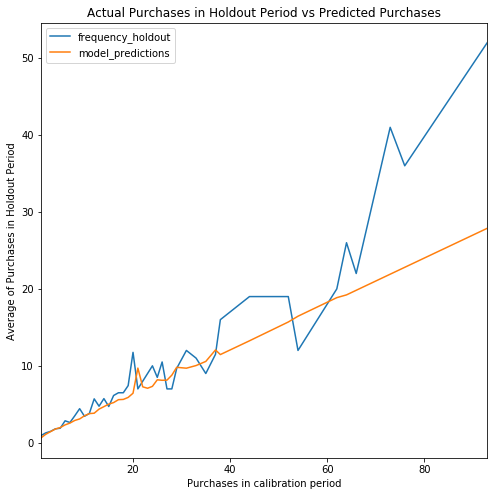

In [0]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input_pd, 
  n=90, 
  **{'figsize':(8,8)}
  )

display()

What we see here is that a higher number of purchases in the calibration period predicts a higher average number of purchases in the holdout period but the actual values diverge sharply from model predictions when we consider customers with a large number of purchases (>60) in the calibration period.  Thinking back to the charts in the data exploration section of this notebook, you might recall that there are very few customers with such a large number of purchases so that this divergence may be a result of a very limited number of instances at the higher end of the frequency range. More data may bring the predicted and actuals back together at this higher end of the curve.  If this divergence persists, it may indicate a range of customer engagement frequency above which we cannot make reliable predictions.

Using the same method call, we can visualize time since last purchase relative to the average number of purchases in the holdout period. This visualization illustrates that as time since the last purchase increases, the number of purchases in the holdout period decreases.  In otherwords, those customers we haven't seen in a while aren't likely coming back anytime soon:

NOTE As before, we will hide the code in the following cells to focus on the visualizations.  Use **Show code** to see the associated Python logic.

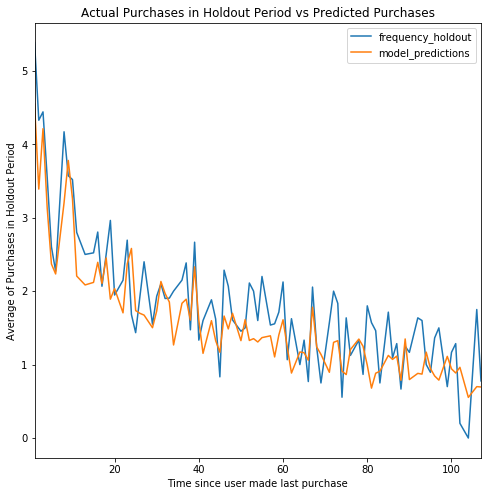

In [0]:
plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input_pd, 
  kind='time_since_last_purchase', 
  n=90, 
  **{'figsize':(8,8)}
  )

display()

Plugging the age of the customer at the time of the last purchase into the chart shows that the timing of the last purchase in a customer's lifecycle doesn't seem to have a strong influence on the number of purchases in the holdout period until a customer becomes quite old.  This would indicate that the customers that stick around a long while are likely to be more frequently engaged:

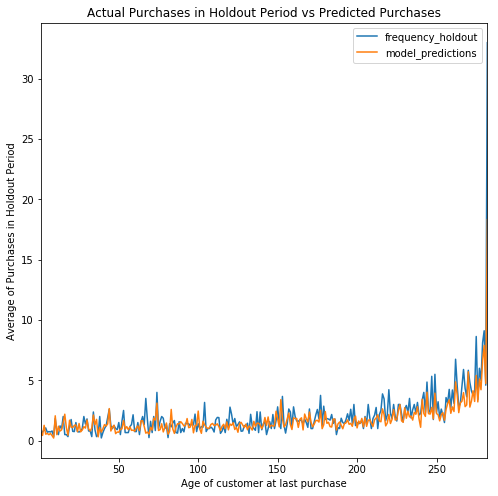

In [0]:
plot_calibration_purchases_vs_holdout_purchases(
  model, 
  input_pd, 
  kind='recency_cal', 
  n=300,
  **{'figsize':(8,8)}
  )

display()

From a quick visual inspection, it's fair to say our model isn't perfect but there are some useful patterns that it captures. Using these patterns, we might calculate the probability a customer remains engaged:

In [0]:
# add a field with the probability a customer is currently "alive"
filtered_pd['prob_alive']=model.conditional_probability_alive(
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )

filtered_pd.head(10)

,frequency,recency,T,prob_alive
CustomerID,,,,
12347,6.0,365.0,367.0,0.998029
12348,3.0,283.0,358.0,0.990016
12352,6.0,260.0,296.0,0.995830
12356,2.0,303.0,325.0,0.989450
12358,1.0,149.0,150.0,0.874308
12359,5.0,324.0,331.0,0.997350
12360,2.0,148.0,200.0,0.982639
12362,12.0,292.0,295.0,0.999015
12363,1.0,133.0,242.0,0.761270


The prediction of the customer's probability of being alive could be very interesting for the application of the model to our marketing processes.  But before exploring model deployment, let's take a look at how this probability changes as customers re-engage by looking at the history of a single customer with modest activity in the dataset, CustomerID 12383:

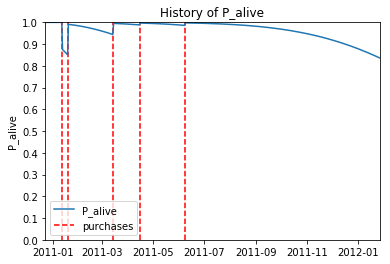

In [0]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

# clear past visualization instructions
plt.clf()

# customer of interest
CustomerID = '12383'

# grab customer's metrics and transaction history
cmetrics_pd = input_pd[input_pd['CustomerID']==CustomerID]
trans_history = orders_pd.loc[orders_pd['CustomerID'] == CustomerID]

# calculate age at end of dataset
days_since_birth = 400

# plot history of being "alive"
plot_history_alive(
  model, 
  days_since_birth, 
  trans_history, 
  'InvoiceDate'
  )

display()

From this chart, we can see this customer made his or her first purchase in January 2011 followed by a repeat purchase later that month.  There was about a 1-month lull in activity during which the probability of the customer being alive declined slightly but with purchases in March, April and June of that year, the customer sent repeated signals that he or she was engaged. Since that last June purchase, the customer hasn't been seen in our transaction history, and our belief that the customer remains engaged has been dropping though as a moderate pace given the signals previously sent.

How does the model arrive at these probabilities? The exact math is tricky but by plotting the probability of being alive as a heatmap relative to frequency and recency, we can understand the probabilities assigned to the intersections of these two values:

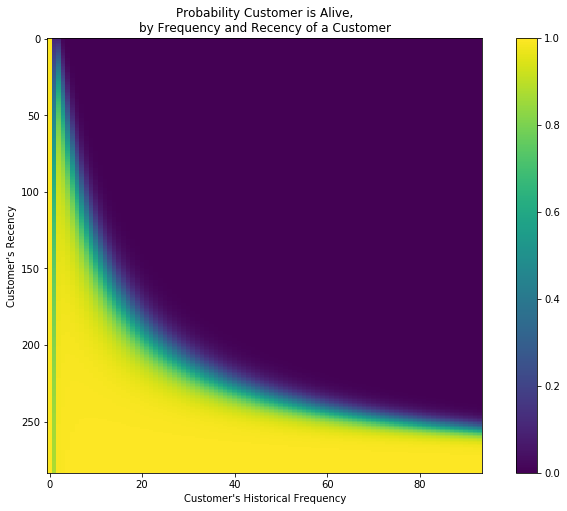

In [0]:
from lifetimes.plotting import plot_probability_alive_matrix

# set figure size
plt.subplots(figsize=(12, 8))

plot_probability_alive_matrix(model)

display()

In addition to predicting the probability a customer is still alive, we can calculate the number of purchases expected from a customer over a given future time interval, such as over the next 30-days:

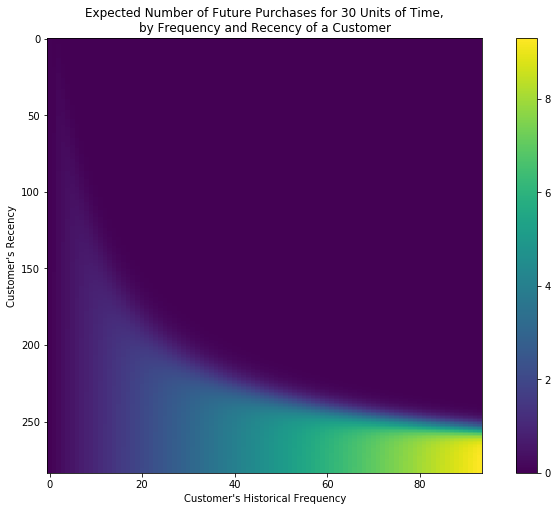

In [0]:
from lifetimes.plotting import plot_frequency_recency_matrix

# set figure size
plt.subplots(figsize=(12, 8))

plot_frequency_recency_matrix(model, T=30)

display()

As before, we can calculate this probability for each customer based on their current metrics:

In [0]:
filtered_pd['purchases_next30days']=(
  model.conditional_expected_number_of_purchases_up_to_time(
    30, 
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )
  )

filtered_pd.head(10)

,frequency,recency,T,prob_alive,purchases_next30days
CustomerID,,,,,
12347,6.0,365.0,367.0,0.998029,0.501273
12348,3.0,283.0,358.0,0.990016,0.272429
12352,6.0,260.0,296.0,0.995830,0.613103
12356,2.0,303.0,325.0,0.989450,0.211995
12358,1.0,149.0,150.0,0.874308,0.226116
12359,5.0,324.0,331.0,0.997350,0.466909
12360,2.0,148.0,200.0,0.982639,0.330980
12362,12.0,292.0,295.0,0.999015,1.190767
12363,1.0,133.0,242.0,0.761270,0.127368


###Step 6: Deploy the Model for Predictions

There are numerous ways we might make use of the trained BTYD model.  We may wish to understand the probability a customer is still engaged.  We may also wish to predict the number of purchases expected from the customer over some number of days.  All we need to make these predictions is our trained model and values of frequency, recency and age (T) for the customer as demonstrated here:

In [0]:
frequency = 6
recency = 255
T = 300
t = 30

print('Probability of Alive: {0}'.format( model.conditional_probability_alive(frequency, recency, T) ))
print('Expected Purchases in next {0} days: {1}'.format(t, model.conditional_expected_number_of_purchases_up_to_time(t, frequency, recency, T) ))

Probability of Alive: 0.9949186328353091
Expected Purchases in next 30 days: 0.6048476679280559

The challenge now is to package our model into something we could re-use for this purpose. Earlier, we used mlflow in combination with hyperopt to capture model runs during the hyperparameter tuning exercise. As a platform, mlflow is designed to solve a wide range of challenges that come with model development and deployment, including the deployment of models as functions and microservice applications. 

MLFlow tackles deployment challenges out of the box for a number of [popular model types](https://www.mlflow.org/docs/latest/models.html#built-in-model-flavors). However, lifetimes models are not one of these. To use mlflow as our deployment vehicle, we need to write a custom wrapper class which translates the standard mlflow API calls into logic which can be applied against our model.

To illustrate this, we've implemented a wrapper class for our lifetimes model which maps the mlflow *predict()* method to multiple prediction calls against our model.  Typically, we'd map *predict()* to a single prediction but we've bumped up the complexity of the returned result to show one of many ways the wrapper may be employed to implement custom logic:

In [0]:
import mlflow
import mlflow.pyfunc

# create wrapper for lifetimes model
class _lifetimesModelWrapper(mlflow.pyfunc.PythonModel):
  
    def __init__(self, lifetimes_model):
        self.lifetimes_model = lifetimes_model

    def predict(self, context, dataframe):
      
      # access input series
      frequency = dataframe.iloc[:,0]
      recency = dataframe.iloc[:,1]
      T = dataframe.iloc[:,2]
      
      # calculate probability currently alive
      results = pd.DataFrame( 
                  self.lifetimes_model.conditional_probability_alive(frequency, recency, T),
                  columns=['alive']
                  )
      # calculate expected purchases for provided time period
      results['purch_15day'] = self.lifetimes_model.conditional_expected_number_of_purchases_up_to_time(15, frequency, recency, T)
      results['purch_30day'] = self.lifetimes_model.conditional_expected_number_of_purchases_up_to_time(30, frequency, recency, T)
      results['purch_45day'] = self.lifetimes_model.conditional_expected_number_of_purchases_up_to_time(45, frequency, recency, T)
      
      return results[['alive', 'purch_15day', 'purch_30day', 'purch_45day']]

We now need to register our model with mlflow. As we do this, we inform it of the wrapper that maps its expected API to the model's functionality.  We also provide environment information to instruct it as to which libraries it needs to install and load for our model to work:

NOTE We would typically train and log our model as a single step but in this notebook we've separated the two actions in order to focus here on custom model deployment.  For examine more common patterns of mlflow implementation, please refer to [this](https://docs.databricks.com/applications/mlflow/model-example.html) and other examples available online.

In [0]:
# add lifetimes to conda environment info
conda_env = mlflow.pyfunc.get_default_conda_env()
conda_env['dependencies'][1]['pip'] += ['lifetimes==0.10.1'] # version should match version installed at top of this notebook

# save model run to mlflow
with mlflow.start_run(run_name='deployment run') as run:
  mlflow.pyfunc.log_model(
    'model', 
    python_model=_lifetimesModelWrapper(model), 
    conda_env=conda_env
    )

Now that our model along with its dependency information and class wrapper have been recorded, let's use mlflow to convert the model into a function we can employ against a Spark DataFrame:

In [0]:
from pyspark.sql.types import ArrayType, FloatType

# define the schema of the values returned by the function
result_schema = ArrayType(FloatType())

# define function based on mlflow recorded model
probability_alive_udf = mlflow.pyfunc.spark_udf(
  spark, 
  'runs:/{0}/model'.format(run.info.run_id), 
  result_type=result_schema
  )

# register the function for use in SQL
_ = spark.udf.register('probability_alive', probability_alive_udf)

Assuming we had access to customer metrics for frequency, recency and age, we can now use our function to generate some predictions:

In [0]:
# create a temp view for SQL demonstration (next cell)
filtered.createOrReplaceTempView('customer_metrics')

# demonstrate function call on Spark DataFrame
display(
  filtered
    .withColumn(
      'predictions', 
      probability_alive_udf(filtered.frequency, filtered.recency, filtered.T)
      )
    .selectExpr(
      'customerid', 
      'predictions[0] as prob_alive', 
      'predictions[1] as purch_15day', 
      'predictions[2] as purch_30day', 
      'predictions[3] as purch_45day'
      )
  )

customerid,prob_alive,purch_15day,purch_30day,purch_45day
12347,0.99802893,0.25069126,0.50127274,0.7517487
12348,0.99001604,0.13625044,0.27242857,0.4085386
12352,0.9958301,0.30663317,0.61310196,0.9194168
12356,0.9894504,0.1060325,0.21199518,0.3178914
12358,0.8743076,0.113154866,0.22611618,0.33890733
12359,0.9973501,0.23351312,0.4669092,0.7001932
12360,0.9826387,0.16557297,0.33097973,0.49623367
12362,0.9990152,0.59553087,1.1907713,1.7857268
12363,0.76127005,0.063720696,0.12736756,0.19094677
12364,0.99436814,0.39505592,0.7895588,1.1835755


In [0]:
%sql -- predict probabiliies customer is alive and will return in 15, 30 & 45 days

SELECT
  x.CustomerID,
  x.prediction[0] as prob_alive,
  x.prediction[1] as purch_15day,
  x.prediction[2] as purch_30day,
  x.prediction[3] as purch_45day
FROM (
  SELECT
    CustomerID,
    probability_alive(frequency, recency, T) as prediction
  FROM customer_metrics
  ) x;

CustomerID,prob_alive,purch_15day,purch_30day,purch_45day
12347,0.99802893,0.25069126,0.50127274,0.7517487
12348,0.99001604,0.13625044,0.27242857,0.4085386
12352,0.9958301,0.30663317,0.61310196,0.9194168
12356,0.9894504,0.1060325,0.21199518,0.3178914
12358,0.8743076,0.113154866,0.22611618,0.33890733
12359,0.9973501,0.23351312,0.4669092,0.7001932
12360,0.9826387,0.16557297,0.33097973,0.49623367
12362,0.9990152,0.59553087,1.1907713,1.7857268
12363,0.76127005,0.063720696,0.12736756,0.19094677
12364,0.99436814,0.39505592,0.7895588,1.1835755


With our lifetimes model now registered as a function, we can incorporate customer lifetime probabilities into our ETL batch, streaming and interactive query workloads.  Levering additional model deployment capabilities of mlflow, our model may also be deployed as a standalone webservice leveraging [AzureML](https://docs.azuredatabricks.net/_static/notebooks/mlflow/mlflow-quick-start-deployment-azure.html) and [AWS Sagemaker](https://docs.databricks.com/_static/notebooks/mlflow/mlflow-quick-start-deployment-aws.html).